# Import Statements

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Apply the default theme
sns.set_theme()

# CD to directory

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/MyDrive/dl_Small_Project/

/content/gdrive/.shortcut-targets-by-id/1i4EWnD3rTI49D40fIp4sdj2kEFPc1E1w/dl_Small_Project


# Dataset Visualisation

# New section

In [4]:
# Number of images in each part of the dataset
dataset_numbers = {'train_normal': 1341,\
                   'train_infected_non-covid': 2530,\
                   'train_infected_covid' : 1345,\
                   'val_normal': 8,\
                   'val_infected_non-covid': 8,\
                   'val_infected_covid': 8, \
                   'test_normal': 234,\
                   'test_infected_non-covid': 242,\
                   'test_infected_covid': 138}

dataset_numbers_normal = {'train_normal': 1341,\
                          'train_infected': 2530+1345,\
                          #'train_infected_covid' : 1345,\
                          #'val_normal': 8,\
                          #'val_infected_non-covid': 8,\
                          #'val_infected_covid': 8, \
                          'test_normal': 234,\
                          'test_infected': 242+138}
                          #'test_infected_covid': 138}


dataset_numbers_infected = {#'train_normal': 1341,\
                          'train_infected_non-covid': 2530,\
                          'train_infected_covid' : 1345,\
                          #'val_normal': 8,\
                          #'val_infected_non-covid': 8,\
                          #'val_infected_covid': 8, \
                          #'test_normal': 234,\
                          'test_infected_non-covid': 242, \
                          'test_infected_covid': 138}

#print(dataset_numbers)

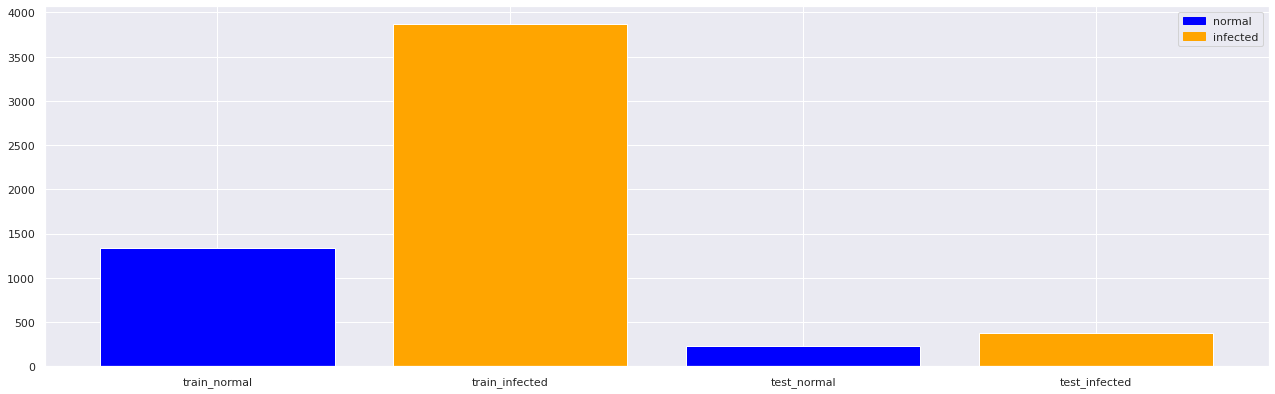

In [ ]:
# Data distribution graph for Normal vs Infected 
fig = plt.figure(figsize=([17, 5]))
ax = fig.add_axes([0,0,1,1])
dataset_names_normal = dataset_numbers_normal.keys()
dataset_counts_normal = dataset_numbers_normal.values()
ax.bar(dataset_names_normal, dataset_counts_normal, color=['blue', 'orange', 'blue', 'orange'])

colors = {'normal': 'blue', 'infected': 'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

For above graph, we combine the infected_non-covid images and infected_covid images to form the larger infected class. As you can see from the graph above, the dataset is unbalanced, skewing heavily towards our infected samples on both the train and test set. The train_infected is about 3.5x the train_normal size whilst the test set are closer in size with about 0.5x discrepancy.

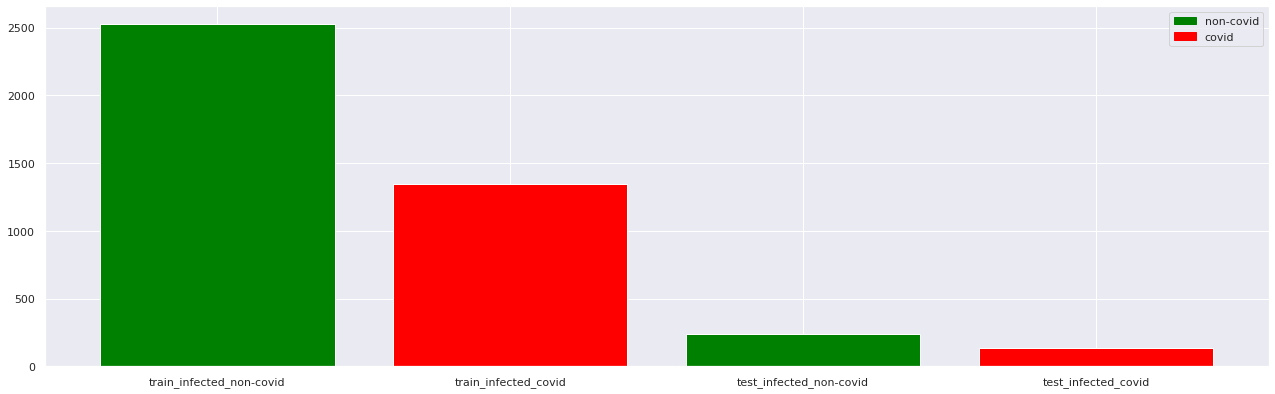

In [ ]:
# Data distribution graph for Non-Covid vs Covid
fig = plt.figure(figsize=([17, 5]))
ax = fig.add_axes([0,0,1,1])
dataset_names_infected = dataset_numbers_infected.keys()
dataset_counts_infected = dataset_numbers_infected.values()
ax.bar(dataset_names_infected, dataset_counts_infected, color=['green', 'red', 'green', 'red'])

colors = {'non-covid': 'green', 'covid': 'red'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

For above graph, we compare only the distribution of the infected_non-covid images and infected_covid images. As you can see from the graph above, the dataset is unbalanced, skewing heavily towards our non-covid samples on both the train and test set. The non-covid train and test set is about 2x the size of the covid train and test set respectively.

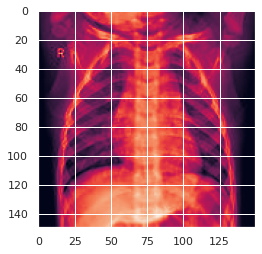

In [ ]:
# Display an image of normal lungs
path_to_file = './dataset/train/normal/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

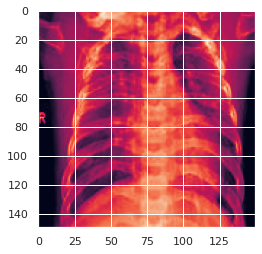

In [ ]:
# Display an image of infected_non-covid lungs
path_to_file = './dataset/train/infected/non-covid/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

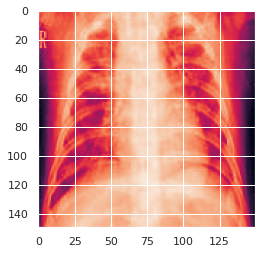

In [ ]:
# Display an image of infected_non-covid lungs
path_to_file = './dataset/train/infected/covid/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()

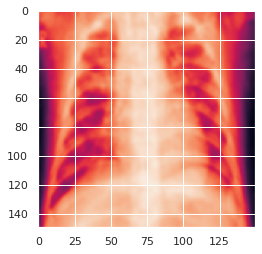

In [ ]:
# Display an image of infected_non-covid lungs
path_to_file = './dataset/train/infected/covid/1.jpg'
with open(path_to_file, 'rb') as f:
    im = cv2.resize(np.asarray(Image.open(f)), (150, 150))
    im = cv2.GaussianBlur(im, (5,5), 0)
    im = im/255
    plt.imshow(im)
f.close()

Based on images and tests we do not believe that data augmentation will help as images are all standard sizes and applying any geometric augmentation would not make sense due to the standardised nature of medical x-rays. We also would not want to apply photometric deformations because they are important in helping the model determine between classes.

# Creating a Normal/Infected train Dataset object

In [5]:
class Lung_Train_Dataset_Normal(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_non-covid': 2530,\
                                'train_infected_covid': 1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_normal': './dataset/train/normal/',\
                              'train_infected_non-covid': './dataset/train/infected/non-covid/',\
                              'train_infected_covid': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [6]:
ld_train_normal = Lung_Train_Dataset_Normal()
ld_train_normal.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_non-covid, in folder ./dataset/train/infected/non-covid/: 2530 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.



In [7]:
print(len(ld_train_normal))

5216


In [8]:
# train_normal test
im, class_oh = ld_train_normal[64]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([1., 0.])


In [9]:
# train_infected_non-covid test
im, class_oh = ld_train_normal[1341]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0902, 0.0980, 0.1137,  ..., 0.0510, 0.0314, 0.0275],
         [0.0902, 0.1020, 0.1176,  ..., 0.0510, 0.0353, 0.0275],
         [0.1020, 0.1098, 0.1255,  ..., 0.0549, 0.0353, 0.0314],
         ...,
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588]]])
tensor([0., 1.])


In [10]:
# train_infected_covid test
im, class_oh = ld_train_normal[5000]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.1608, 0.1686, 0.1804,  ..., 0.1647, 0.1804, 0.1922],
         [0.1608, 0.1647, 0.1804,  ..., 0.1647, 0.1725, 0.1804],
         [0.1569, 0.1608, 0.1725,  ..., 0.1686, 0.1647, 0.1647],
         ...,
         [0.0902, 0.0863, 0.0824,  ..., 0.3608, 0.4902, 0.5412],
         [0.0902, 0.0863, 0.0824,  ..., 0.3804, 0.5020, 0.5490],
         [0.0902, 0.0863, 0.0824,  ..., 0.3843, 0.5059, 0.5490]]])
tensor([0., 1.])


# Creating a Infected_COVID/Infected_non-COVID Train Dataset object

In [11]:
class Lung_Train_Dataset_Infected(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'infected_non-covid', 1: 'infected_covid'}
        
        
        # The dataset consists only of training images
        self.groups = 'train'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_infected_non-covid': 2530,\
                                'train_infected_covid': 1345}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'train_infected_non-covid': './dataset/train/infected/non-covid/',\
                              'train_infected_covid': './dataset/train/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the training dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'infected_non-covid' or 'infected_covid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        #second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'infected_non-covid'
            label = torch.Tensor([1, 0])
        # elif index < first_val + second_val:
        #     class_val = 'infected_non-covid'
        #     index = index - first_val 
        #     label = torch.Tensor([0, 1])
        else: 
            class_val = 'infected_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

## Test Statements

In [12]:
ld_train_infected = Lung_Train_Dataset_Infected()
ld_train_infected.describe()

This is the training dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 3875 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_infected_non-covid, in folder ./dataset/train/infected/non-covid/: 2530 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.



In [13]:
print(len(ld_train_infected))

3875


In [14]:
# train_infected_non-covid test
im, class_oh = ld_train_infected[0]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0902, 0.0980, 0.1137,  ..., 0.0510, 0.0314, 0.0275],
         [0.0902, 0.1020, 0.1176,  ..., 0.0510, 0.0353, 0.0275],
         [0.1020, 0.1098, 0.1255,  ..., 0.0549, 0.0353, 0.0314],
         ...,
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588],
         [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0588]]])
tensor([1., 0.])


In [15]:
# train_infected_covid test
im, class_oh = ld_train_infected[2530]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2980, 0.3059, 0.3216,  ..., 0.1333, 0.1098, 0.0980],
         [0.3020, 0.3098, 0.3294,  ..., 0.1294, 0.1059, 0.0980],
         [0.3059, 0.3176, 0.3412,  ..., 0.1255, 0.1059, 0.0980],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([0., 1.])


# Creating a Normal/Infected test Dataset object

In [16]:
class Lung_Test_Dataset_Normal(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'test_normal': 234,\
                                'test_infected_non-covid': 242,\
                                'test_infected_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'test_normal': './dataset/test/normal/',\
                              'test_infected_non-covid': './dataset/test/infected/non-covid/',\
                              'test_infected_covid': './dataset/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'test'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [17]:
ld_test_normal = Lung_Test_Dataset_Normal()
ld_test_normal.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_non-covid, in folder ./dataset/test/infected/non-covid/: 242 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 138 images.



In [18]:
im, class_oh = ld_test_normal[18]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         [0.0118, 0.0118, 0.0118,  ..., 0.0235, 0.0235, 0.0235],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0196, 0.0196]]])
tensor([1., 0.])


In [19]:
im, class_oh = ld_test_normal[234]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0667, 0.0784, 0.1020,  ..., 0.3725, 0.3529, 0.3451],
         [0.0667, 0.0745, 0.1020,  ..., 0.3686, 0.3490, 0.3412],
         [0.0627, 0.0706, 0.0980,  ..., 0.3608, 0.3373, 0.3294],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([0., 1.])


In [20]:
im, class_oh = ld_test_normal[500]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.2118, 0.1843, 0.1686],
         [0.0039, 0.0039, 0.0039,  ..., 0.2549, 0.2314, 0.2157],
         [0.0078, 0.0039, 0.0039,  ..., 0.3255, 0.3020, 0.2941],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.2667, 0.2471, 0.2353],
         [0.0000, 0.0000, 0.0000,  ..., 0.1765, 0.1647, 0.1569],
         [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.1176, 0.1137]]])
tensor([0., 1.])


## Creating a Infected_COVID/Infected_Non-COVID Test Dataset

In [21]:
class Lung_Test_Dataset_Infected(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'infected_non-covid', 1: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'test'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {
                                'test_infected_non-covid': 242,\
                                'test_infected_covid': 138}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {
                              'test_infected_non-covid': './dataset/test/infected/non-covid/',\
                              'test_infected_covid': './dataset/test/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'test'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'test'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        #second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'infected_non-covid'
            label = torch.Tensor([1, 0])
        else: 
            class_val = 'infected_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

## Test Statements

In [22]:
ld_test_infected = Lung_Test_Dataset_Infected()
ld_test_infected.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 380 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_infected_non-covid, in folder ./dataset/test/infected/non-covid/: 242 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 138 images.



In [23]:
im, class_oh = ld_test_infected[18]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.8118, 0.8118, 0.8039,  ..., 0.1176, 0.0824, 0.0706],
         [0.8118, 0.8078, 0.8039,  ..., 0.1137, 0.0784, 0.0706],
         [0.8078, 0.8078, 0.8078,  ..., 0.0980, 0.0745, 0.0706],
         ...,
         [0.0588, 0.0667, 0.1098,  ..., 0.1529, 0.2196, 0.2510],
         [0.0627, 0.0706, 0.1059,  ..., 0.1569, 0.2275, 0.2627],
         [0.0667, 0.0745, 0.1059,  ..., 0.1608, 0.2314, 0.2667]]])
tensor([1., 0.])


In [24]:
im, class_oh = ld_test_infected[242]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.3843, 0.4000, 0.4275,  ..., 0.1137, 0.1176, 0.1216],
         [0.3961, 0.4118, 0.4353,  ..., 0.1059, 0.1098, 0.1137],
         [0.4235, 0.4314, 0.4549,  ..., 0.0980, 0.0980, 0.0941],
         ...,
         [0.1686, 0.1647, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1647, 0.1608, 0.1569,  ..., 0.1569, 0.1569, 0.1569],
         [0.1647, 0.1608, 0.1569,  ..., 0.1569, 0.1569, 0.1569]]])
tensor([0., 1.])


# Creating a Normal/Infected Val Dataset object

In [25]:
class Lung_Val_Dataset_Normal(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'normal', 1: 'infected_non-covid', 2: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'val_normal': 8,\
                                'val_infected_non-covid': 8,\
                                'val_infected_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {'val_normal': './dataset/val/normal/',\
                              'val_infected_non-covid': './dataset/val/infected/non-covid/',\
                              'val_infected_covid': './dataset/val/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the test dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0])
        elif index < first_val + second_val:
            class_val = 'infected_non-covid'
            index = index - first_val 
            label = torch.Tensor([0, 1])
        else: 
            class_val = 'infected_covid'
            index = index - first_val - second_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

### Test Statements

In [26]:
ld_val_normal = Lung_Val_Dataset_Normal()
ld_val_normal.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_non-covid, in folder ./dataset/val/infected/non-covid/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 8 images.



In [27]:
print(len(ld_val_normal))

24


In [28]:
im, class_oh = ld_val_normal[3]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.2078, 0.2353, 0.2706,  ..., 0.0902, 0.0745, 0.0706],
         [0.2275, 0.2549, 0.2941,  ..., 0.0863, 0.0745, 0.0706],
         [0.2706, 0.2941, 0.3333,  ..., 0.0824, 0.0745, 0.0745],
         ...,
         [0.0039, 0.0039, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.0078, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
tensor([1., 0.])


In [29]:
im, class_oh = ld_val_normal[8]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0706, 0.0745, 0.0863,  ..., 0.1059, 0.0863, 0.0784],
         [0.0745, 0.0784, 0.0902,  ..., 0.1216, 0.0980, 0.0902],
         [0.0745, 0.0824, 0.1020,  ..., 0.1490, 0.1255, 0.1137],
         ...,
         [0.0353, 0.0314, 0.0235,  ..., 0.0078, 0.0118, 0.0157],
         [0.0431, 0.0353, 0.0235,  ..., 0.0078, 0.0196, 0.0275],
         [0.0471, 0.0392, 0.0235,  ..., 0.0118, 0.0235, 0.0353]]])
tensor([0., 1.])


In [30]:
im, class_oh = ld_val_normal[20]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0039, 0.0039, 0.0000,  ..., 0.2431, 0.2392, 0.2275],
         [0.0039, 0.0039, 0.0000,  ..., 0.2157, 0.2118, 0.1961],
         [0.0078, 0.0078, 0.0039,  ..., 0.1569, 0.1529, 0.1412],
         ...,
         [0.2196, 0.2118, 0.1725,  ..., 0.0000, 0.0039, 0.0078],
         [0.2980, 0.2863, 0.2314,  ..., 0.0039, 0.0118, 0.0157],
         [0.3333, 0.3216, 0.2627,  ..., 0.0078, 0.0157, 0.0235]]])
tensor([0., 1.])


# Creating a Infected_COVID/Infected_Non-COVID Validation Dataset

In [31]:
class Lung_Val_Dataset_Infected(Dataset):
    
    def __init__(self):
        """
        Constructor for generic Dataset class - simply assembles
        the important parameters in attributes.
        """
        
        # All images are of size 150 x 150
        self.img_size = (150, 150)
        
        # Only two classes will be considered here (normal and infected)
        self.classes = {0: 'infected_non-covid', 1: 'infected_covid'}
        
        # The dataset consists only of test images
        self.groups = 'val'
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {
                                'val_infected_non-covid': 8,\
                                'val_infected_covid': 8}
        
        # Path to images for different parts of the dataset
        self.dataset_paths = {
                              'val_infected_non-covid': './dataset/val/infected/non-covid/',\
                              'val_infected_covid': './dataset/val/infected/covid/'}
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the Validation dataset of the Lung Dataset"
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'infected_non-covid' or 'infected_covid'."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Resize to make sure all imgs standardised dim
            im = cv2.resize(np.asarray(Image.open(f)), self.img_size)
            # Remove img noise
            im = cv2.GaussianBlur(im, (5,5), 0)
            # Normalize data
            im = im/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'val'.
        - class_val variable should be set to 'normal', 'infected_non-covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)
        
        
    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        #second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'infected_non-covid'
            label = torch.Tensor([1, 0])
        else: 
            class_val = 'infected_covid'
            index = index - first_val
            label = torch.Tensor([0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

## Test Statements

In [32]:
ld_val_infected = Lung_Val_Dataset_Infected()
ld_val_infected.describe()

This is the Validation dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 16 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_infected_non-covid, in folder ./dataset/val/infected/non-covid/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 8 images.



In [33]:
print(len(ld_val_infected))

16


In [34]:
im, class_oh = ld_val_infected[2]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.3922, 0.3804, 0.3569,  ..., 0.0039, 0.0039, 0.0039],
         [0.4000, 0.3922, 0.3804,  ..., 0.0039, 0.0039, 0.0039],
         [0.4196, 0.4431, 0.4706,  ..., 0.0000, 0.0039, 0.0039],
         ...,
         [0.0471, 0.0588, 0.0863,  ..., 0.0078, 0.0157, 0.0196],
         [0.0392, 0.0510, 0.0824,  ..., 0.0039, 0.0078, 0.0078],
         [0.0314, 0.0471, 0.0784,  ..., 0.0000, 0.0039, 0.0039]]])
tensor([1., 0.])


In [35]:
im, class_oh = ld_val_infected[8]
print(im.shape)
print(im)
print(class_oh)

torch.Size([1, 150, 150])
tensor([[[0.0039, 0.0078, 0.0157,  ..., 0.2667, 0.2431, 0.2235],
         [0.0078, 0.0078, 0.0157,  ..., 0.2314, 0.2118, 0.1922],
         [0.0118, 0.0118, 0.0157,  ..., 0.1725, 0.1529, 0.1412],
         ...,
         [0.2549, 0.2549, 0.2196,  ..., 0.0039, 0.0039, 0.0078],
         [0.3333, 0.3333, 0.2902,  ..., 0.0039, 0.0118, 0.0196],
         [0.3686, 0.3686, 0.3255,  ..., 0.0078, 0.0196, 0.0275]]])
tensor([0., 1.])


# Creating a Dataloader object

In [36]:
# Batch size value to be used (to be decided freely, but set to 4 for demo)
# bs_val = 8
bs_val = 32

In [37]:
# Dataloader from dataset (train - Normal/Infected)
train_loader_normal = DataLoader(ld_train_normal, batch_size = bs_val, shuffle = True)
print(train_loader_normal)

In [38]:
# Dataloader from dataset (train - Infected_covid/Infected_non-covid)
train_loader_infected = DataLoader(ld_train_infected, batch_size = bs_val, shuffle = True)
print(train_loader_infected)

In [39]:
# Dataloader from dataset (test and val - Normal/Infected)
test_loader_normal = DataLoader(ld_test_normal, batch_size = bs_val, shuffle = True)
print(test_loader_normal)
val_loader_normal = DataLoader(ld_val_normal, batch_size = bs_val, shuffle = True)
print(val_loader_normal)

In [40]:
# Dataloader from dataset (test and val - Infected_covid/Infected_non-covid)
test_loader_infected = DataLoader(ld_test_infected, batch_size = bs_val, shuffle = True)
print(test_loader_infected)
val_loader_infected = DataLoader(ld_val_infected, batch_size = bs_val, shuffle = True)
print(val_loader_infected)

In [41]:
# Typical mini-batch for loop on dataloader (train)
for k, v in enumerate(train_loader_normal):
    print("-----")
    print(k)
    print(v[0])
    print(v[1])
    # Forced stop
    break
    #assert False, "Forced stop after one iteration of the for loop"

-----
0
tensor([[[[0.0784, 0.0824, 0.0863,  ..., 0.0863, 0.0667, 0.0588],
          [0.0784, 0.0824, 0.0863,  ..., 0.0863, 0.0667, 0.0588],
          [0.0824, 0.0863, 0.0902,  ..., 0.0941, 0.0706, 0.0588],
          ...,
          [0.0039, 0.0078, 0.0235,  ..., 0.0314, 0.0078, 0.0039],
          [0.0078, 0.0118, 0.0275,  ..., 0.0314, 0.0118, 0.0039],
          [0.0078, 0.0157, 0.0314,  ..., 0.0314, 0.0118, 0.0039]]],


        [[[0.4431, 0.4745, 0.5373,  ..., 0.1686, 0.1451, 0.1373],
          [0.4275, 0.4549, 0.5137,  ..., 0.2078, 0.1843, 0.1765],
          [0.4000, 0.4196, 0.4706,  ..., 0.2941, 0.2706, 0.2549],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.2510, 0.2510, 0.2471],
          [0.0039, 0.0000, 0.0039,  ..., 0.1647, 0.1569, 0.1529],
          [0.0000, 0.0000, 0.0039,  ..., 0.1216, 0.1137, 0.1059]]],


        [[[0.4275, 0.4314, 0.4431,  ..., 0.4314, 0.5098, 0.5333],
          [0.4314, 0.4353, 0.4471,  ..., 0.4196, 0.4980, 0.5294],
          [0.4353, 0.4392, 0.4

# Confusion Matrix Function

In [43]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Using our dataloader for training a model

## Complex

training now...
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 12.],
        [ 0., 12.]])
Validation loss: 1.0620583295822144
Validation set accuracy:  66.66666666666667 %
Epoch: 1/5 -  Training Loss: 0.010 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 0., 12.],
        [ 0., 12.]])
Validation loss: 1.7998846769332886
Validation set accuracy:  66.66666666666667 %
Epoch: 1/5 -  Training Loss: 0.293 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 1., 11.],
        [ 2., 10.]])
Validation loss: 0.4937749207019806
Validation set accuracy:  79.16666666666667 %
Epoch: 2/5 -  Training Loss: 0.115 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[ 3.,  9.],
        [ 2., 10.]])
Validation loss: 0.3111477494239807
Validation set accuracy:  87.5 %
Epoch: 2/5 -  Training Loss: 0.123 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[3., 9.],
        [4., 8.]])
Validatio

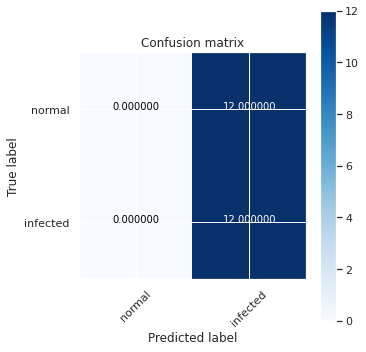

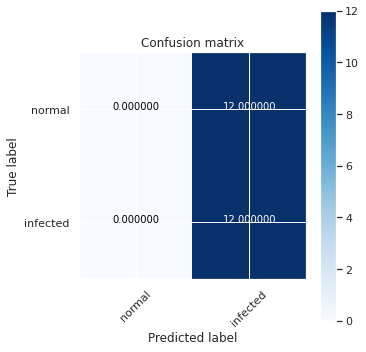

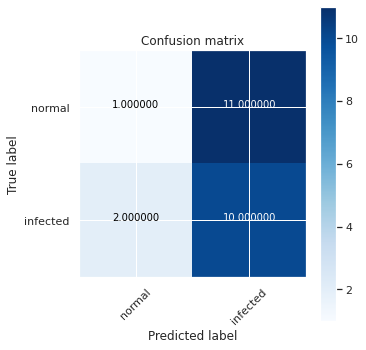

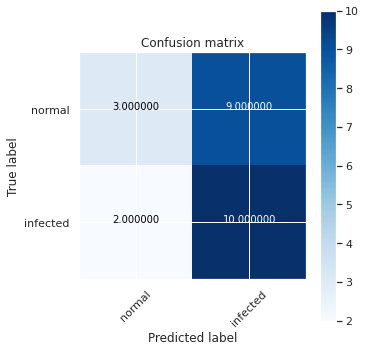

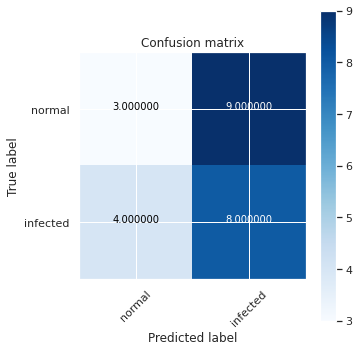

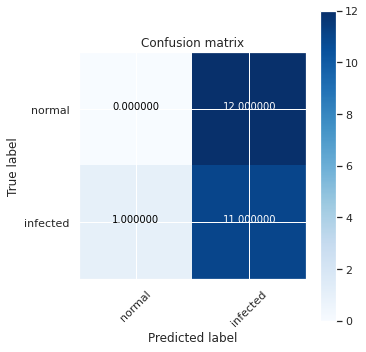

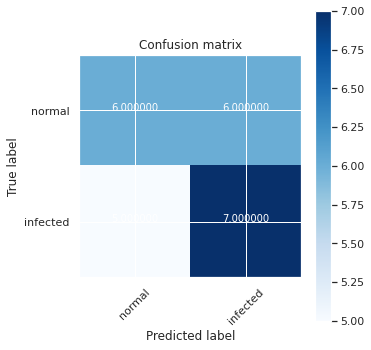

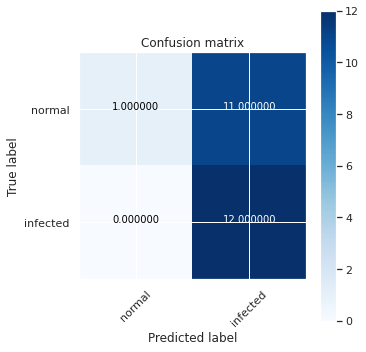

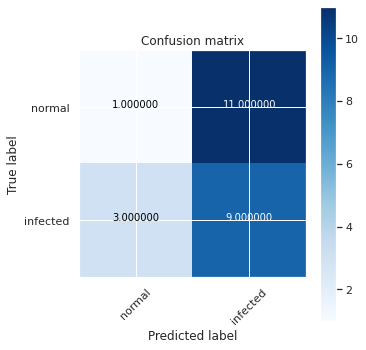

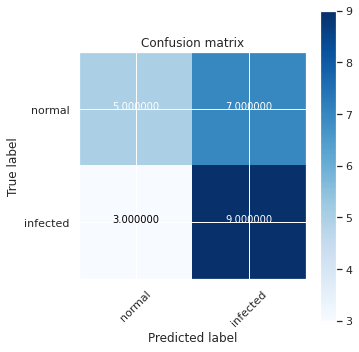

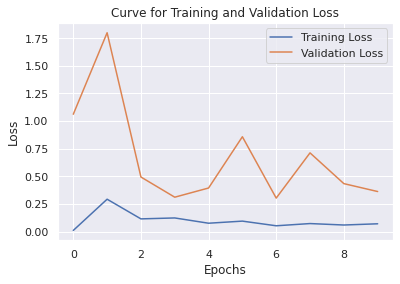

In [48]:
# normal vs infected
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2,bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #input [1,150,150]
        self.conv1 = conv_block(1, 8)
        self.conv2 = conv_block(8, 16)
        self.conv3 = triple_conv(16, 32)
        self.conv4 = triple_conv(32, 64)
        self.conv5 = triple_conv(64, 128)
        self.conv6 = triple_conv(128, 256)
        self.conv7 = conv_block(256, 128,size=1)
        self.conv8 = conv_block(128, 256)
        self.conv9 = conv_block(256, 3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        x = F.max_pool2d(x, 2)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) 
        return output

def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      # scheduler.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()

  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0
    target_label = []
    pred_label = []

    confusion_matrix = torch.zeros(2, 2)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["normal", "infected"] 

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
      
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
def main():
  model = Net()
  optimizer = optim.Adadelta(model.parameters(), lr=1.0)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader_normal, optimizer,  5, val_loader_normal,device)
  torch.save(model, 'complex_model1.pth')
  test(model, test_loader_normal,device)

main()


training now...
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[0., 8.],
        [0., 8.]])
Validation loss: 1.0928404331207275
Validation set accuracy:  50.0 %
Epoch: 1/5 -  Training Loss: 0.011 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[5., 3.],
        [5., 3.]])
Validation loss: 0.6280091404914856
Validation set accuracy:  62.5 %
Epoch: 1/5 -  Training Loss: 0.632 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[8., 0.],
        [8., 0.]])
Validation loss: 0.9698352813720703
Validation set accuracy:  50.0 %
Epoch: 2/5 -  Training Loss: 0.125 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[3., 5.],
        [3., 5.]])
Validation loss: 0.679167628288269
Validation set accuracy:  62.5 %
Epoch: 2/5 -  Training Loss: 0.564 
<class 'torch.Tensor'>
Confusion matrix, without normalization
tensor([[3., 5.],
        [4., 4.]])
Validation loss: 0.843864381313324
Validation set accuracy:  56.2

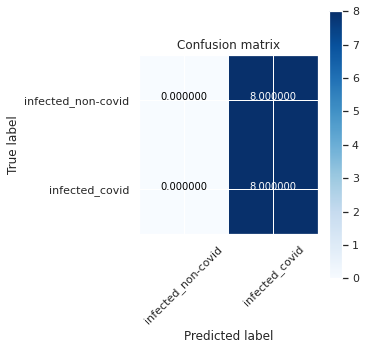

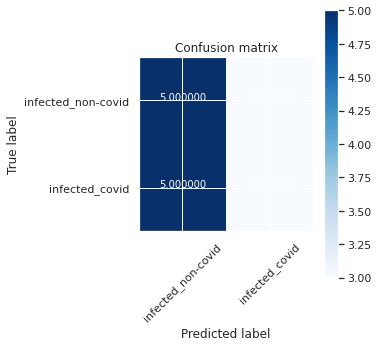

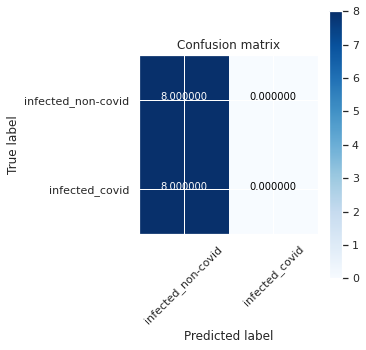

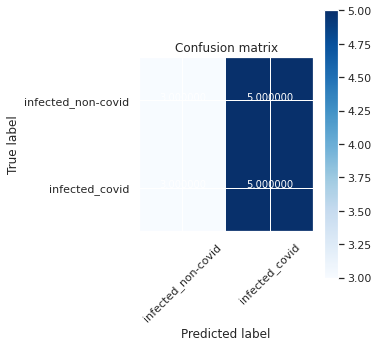

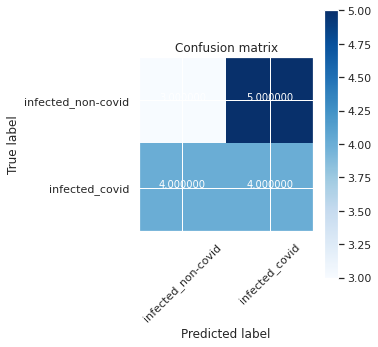

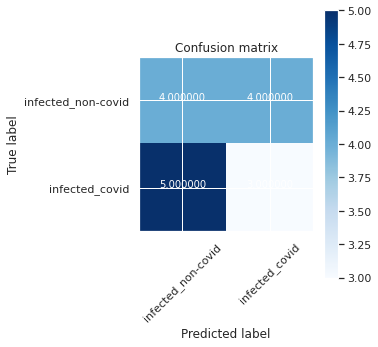

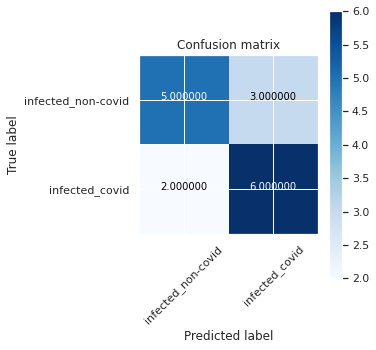

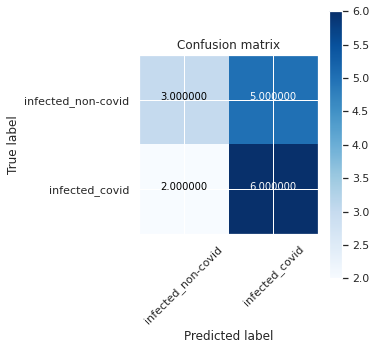

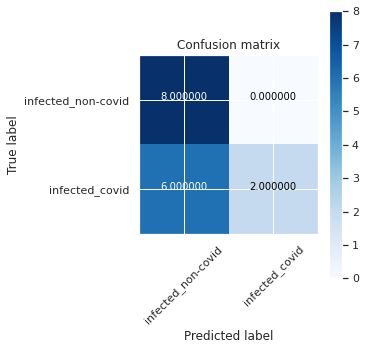

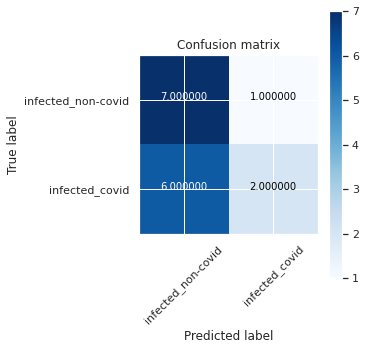

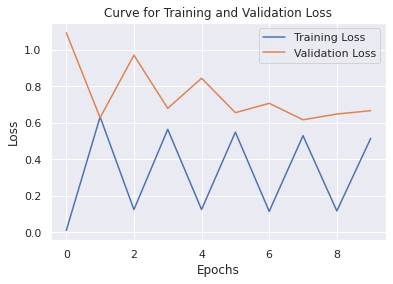

In [47]:
# infected covid vs infected non covid
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2,bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #input [1,150,150]
        self.conv1 = conv_block(1, 8)
        self.conv2 = conv_block(8, 16)
        self.conv3 = triple_conv(16, 32)
        self.conv4 = triple_conv(32, 64)
        self.conv5 = triple_conv(64, 128)
        self.conv6 = triple_conv(128, 256)
        self.conv7 = conv_block(256, 128,size=1)
        self.conv8 = conv_block(128, 256)
        self.conv9 = conv_block(256, 3)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.conv4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        x = F.max_pool2d(x, 2)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1) 
        return output

def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      # scheduler.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()

  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses_1.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0

    confusion_matrix = torch.zeros(2, 2)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["infected_non-covid", "infected_covid"]  # infected_non-covid --> 0, infected_covid --> 1   

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

def main():
  model = Net()
  optimizer = optim.Adadelta(model.parameters(), lr=1.0)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader_infected, optimizer, 5, val_loader_infected,device)
  torch.save(model, 'complexmodel_2.pth')
  test(model, test_loader_infected,device)

main()

## Simple

In [ ]:
# normal vs infected
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 32 output channels, 3 by 3 kernel, stride of 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Conv2D: 1 input channel, 64 output channels, 3 by 3 kernel, stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # fully connected layer with 128 outputs
        self.fc1 = nn.Linear(341056, 128)
        # fully connected layer with 3 outputs
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # print("Input:", x.shape)
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print("After conv2:", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print("After max_pool2d:", x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print("After flatten:", x.shape)
        x = self.fc1(x)
        # print("After fc1:", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        output = F.log_softmax(x, dim=1) 
        # print("Output:", output.shape)
        return output


def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model.forward(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      # scheduler.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()
  
  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses_2.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0

    confusion_matrix = torch.zeros(2, 2)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["normal", "infected"] # infected_non-covid --> 0, infected_covid --> 1   

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
      
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


def main():
  model = Net()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader_normal, optimizer, 5, val_loader_normal,device)
  torch.save(model, '.simplemodel_1.pth')
  test(model, test_loader_normal, device)

main()

In [ ]:
# infected covid vs infected non covid
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 32 output channels, 3 by 3 kernel, stride of 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Conv2D: 1 input channel, 64 output channels, 3 by 3 kernel, stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # fully connected layer with 128 outputs
        self.fc1 = nn.Linear(341056, 128)
        # fully connected layer with 3 outputs
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # print("Input:", x.shape)
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print("After conv2:", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print("After max_pool2d:", x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print("After flatten:", x.shape)
        x = self.fc1(x)
        # print("After fc1:", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        output = F.log_softmax(x, dim=1) 
        # print("Output:", output.shape)
        return output


def train(model, train_loader, optimizer, epoch, val_loader,device):
  train_loss_values = []
  val_loss_values = []
  running_loss = 0
  print_every = 100

  print('training now...')
  start = time.time()

  for e in range(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_infected):
      data, target = data.to(device),target.to(device)
      optimizer.zero_grad()
      output = model.forward(data)
      loss = F.nll_loss(output, torch.max(target, 1)[1])
      loss.backward()
      optimizer.step()
      # scheduler.step()
      running_loss += loss.item()

      if batch_idx % print_every == 0:
        model.eval()
        with torch.no_grad():
          valid_loss, accuracy = validation(model, val_loader,device)
          train_loss_values.append(running_loss/print_every)
          val_loss_values.append(valid_loss/len(val_loader))
          
          print("Epoch: {}/{} - ".format(e+1, epoch),"Training Loss: {:.3f} ".format(running_loss/print_every))
          running_loss=0
          
          model.train()
  
  print('Training Loss Values are: ', train_loss_values,'Validation Loss Values are: ', val_loss_values)
  fig, ax = plt.subplots()
  ax.plot(train_loss_values)
  ax.plot(val_loss_values)
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  ax.set_title('Curve for Training and Validation Loss')
  ax.legend(['Training Loss', 'Validation Loss'])
  fig.savefig('model_losses_3.png')
  # ax.show()

  print(f"Run time: {(time.time() - start)/60:.3f} min")

def validation(model, val_loader, device):
    model.eval()
    correct = 0
    val_loss = 0

    confusion_matrix = torch.zeros(2, 2)

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device),target.to(device)
            output = model.forward(data)
            val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()

            for t, p in zip(target.view(-1), pred.view(-1)):
              confusion_matrix[t.long(), p.long()] += 1
    
    print(type(confusion_matrix))
    classes = ["infected_non-covid", "infected_covid"] # infected_non-covid --> 0, infected_covid --> 1   

    plt.figure(figsize=(5,5))
    plot_confusion_matrix(confusion_matrix, classes)

    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')
    
    return val_loss, accuracy     

def test(model, test_loader, device):
  model.eval() 
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device),target.to(device)
      output = model(data)
      test_loss += F.nll_loss(output, torch.max(target, 1)[1])  # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
      
  test_loss /= len(test_loader.dataset)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))


def main():
  model = Net()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  # scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
  device='cuda'
  model.to(device)
  train(model, train_loader_infected, optimizer, 5, val_loader_infected,device)
  torch.save(model, 'simplemodel_2.pth')
  test(model, test_loader_infected, device)

main()

In [ ]:
from torch import IntTensor
bs_val = 24
val_loader_normal = DataLoader(ld_val_normal, batch_size = bs_val, shuffle = True)
print(val_loader_normal)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 32 output channels, 3 by 3 kernel, stride of 1
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Conv2D: 1 input channel, 64 output channels, 3 by 3 kernel, stride of 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # fully connected layer with 128 outputs
        self.fc1 = nn.Linear(341056, 128)
        # fully connected layer with 3 outputs
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        # print("Input:", x.shape)
        x = self.conv1(x)
        # print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print("After conv2:", x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print("After max_pool2d:", x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print("After flatten:", x.shape)
        x = self.fc1(x)
        # print("After fc1:", x.shape)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        # print("After fc2:", x.shape)
        output = F.log_softmax(x, dim=1) 
        # print("Output:", output.shape)
        return output

def display_performance(model, val_loader, device,size,type):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            images = data.to('cuda')
            output = model.forward(images)
            pred = output.argmax(dim=1, keepdim=True)
            for idx in range(0,size):
              img = np.asarray(data[idx])
              img = img*255
              [img] = np.round(img)           
              plt.imshow(img)
              plt.show()
              val = target[idx]
              outvalue = torch.max(val,0)[1]
              if type == 1:
                if IntTensor.item(outvalue)== 1:
                  outvalue = 'infected'
                else:
                  outvalue = 'normal'
                print('target',outvalue)
            
            #   print('output',output)
                outvalue = pred[idx]
                if IntTensor.item(outvalue)== 1:
                  outvalue = 'infected'
                else:
                  outvalue = 'normal'
                print('pred',outvalue)
              if type == 2:
                if IntTensor.item(outvalue)== 1:
                  outvalue = 'covid'
                else:
                  outvalue = 'non-covid'
                print('target',outvalue)
            
            #   print('output',output)
                outvalue = pred[idx]
                if IntTensor.item(outvalue)== 1:
                  outvalue = 'covid'
                else:
                  outvalue = 'non-covid'
                print('pred',outvalue)
        plt.show()
        data, target = data.to(device),target.to(device)
        output = model.forward(data)
        val_loss += F.nll_loss(output, torch.max(target,1)[1]).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(torch.max(target,1)[1].view_as(pred)).sum().item()
    accuracy = (100. * correct / len(val_loader.dataset))
    print("Validation loss: {}".format(val_loss / len(val_loader)))
    print('Validation set accuracy: ', accuracy, '%')

In [ ]:
def normalvsinfected(PATH):
  device = 'cuda'
  model = Net()
  model= torch.load(PATH)
  model.eval()
  display_performance(model, val_loader_infected, device,size=15,type=1)

def covidvsinfected(PATH):
  device = 'cuda'
  model = Net()
  model= torch.load(PATH)
  model.eval()
  display_performance(model, val_loader_infected, device,size=15,type=2)

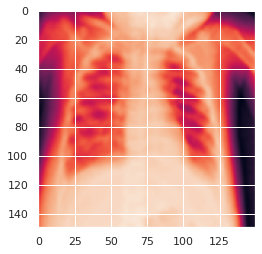

target infected
pred normal


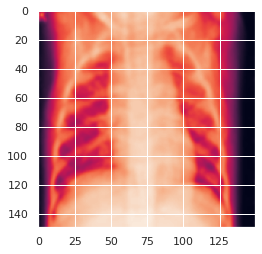

target normal
pred normal


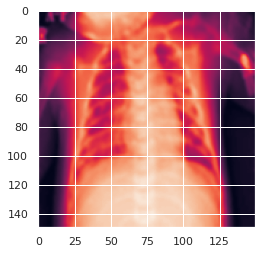

target normal
pred normal


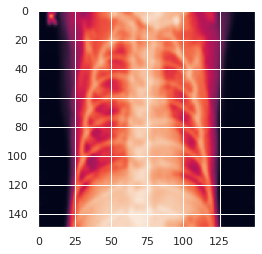

target infected
pred normal


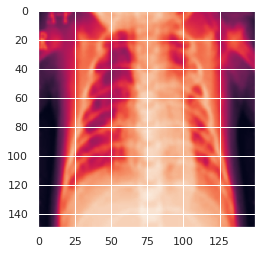

target normal
pred normal


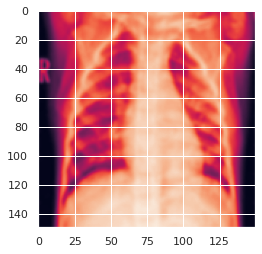

target normal
pred normal


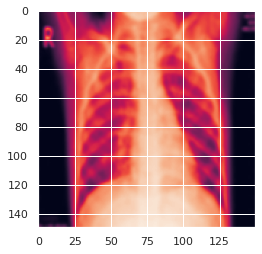

target infected
pred normal


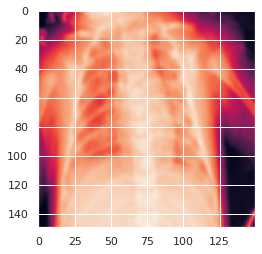

target normal
pred normal


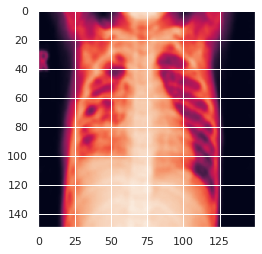

target normal
pred normal


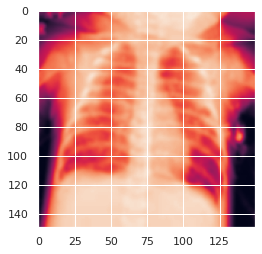

target normal
pred normal


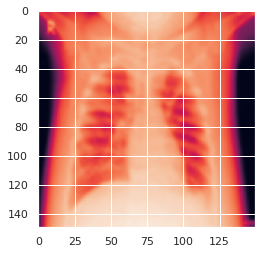

target infected
pred normal


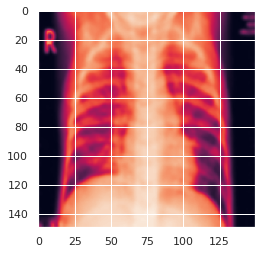

target infected
pred normal


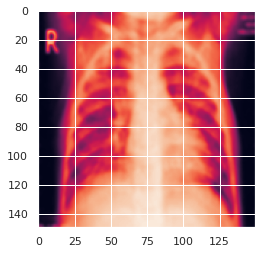

target infected
pred normal


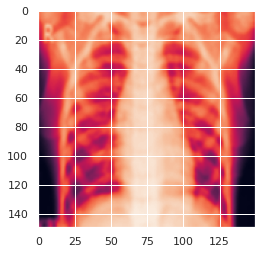

target infected
pred normal


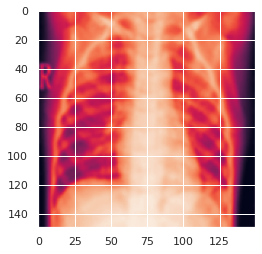

target normal
pred normal
Validation loss: 0.7409745454788208
Validation set accuracy:  50.0 %


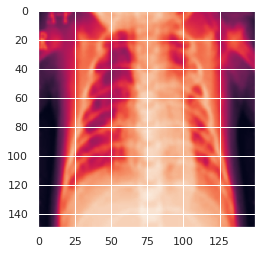

target non-covid
pred non-covid


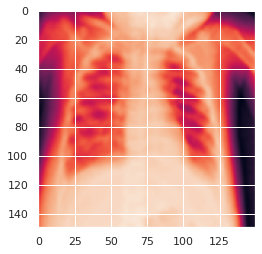

target covid
pred non-covid


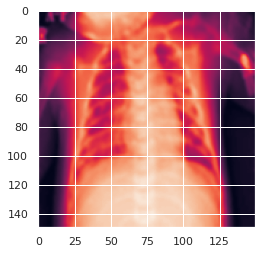

target non-covid
pred non-covid


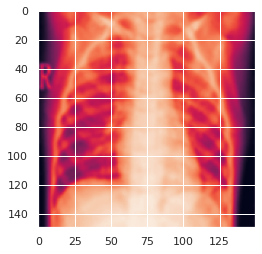

target non-covid
pred covid


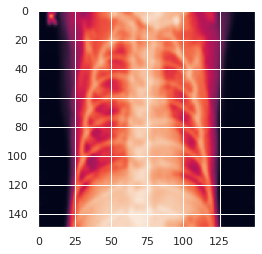

target covid
pred covid


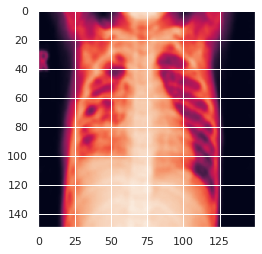

target non-covid
pred covid


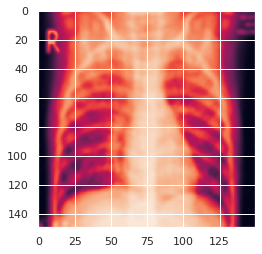

target covid
pred covid


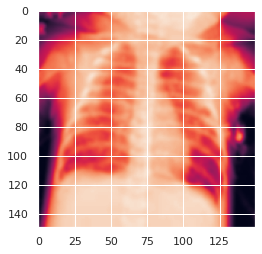

target non-covid
pred non-covid


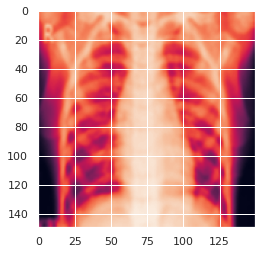

target covid
pred covid


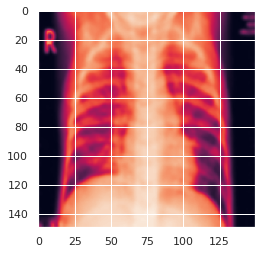

target covid
pred covid


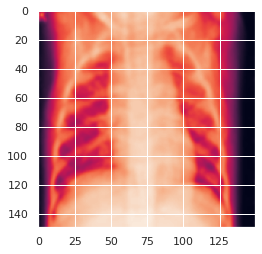

target non-covid
pred covid


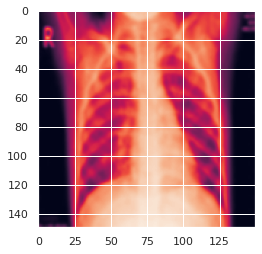

target covid
pred covid


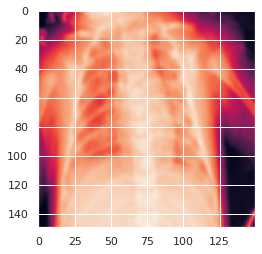

target non-covid
pred non-covid


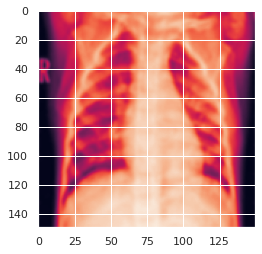

target non-covid
pred covid


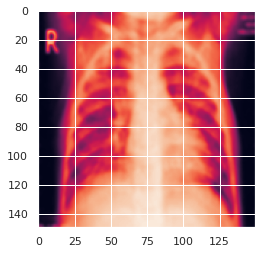

target covid
pred covid
Validation loss: 0.667077898979187
Validation set accuracy:  68.75 %


In [ ]:
normalvsinfected('simplemodel_1.pth')
covidvsinfected('simplemodel_2.pth')